<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Импорт-библиотек" data-toc-modified-id="Импорт-библиотек-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Импорт библиотек</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Загрузка-датасета" data-toc-modified-id="Загрузка-датасета-2.0.0.1"><span class="toc-item-num">2.0.0.1&nbsp;&nbsp;</span>Загрузка датасета</a></span></li><li><span><a href="#Замена-англицизмов" data-toc-modified-id="Замена-англицизмов-2.0.0.2"><span class="toc-item-num">2.0.0.2&nbsp;&nbsp;</span>Замена англицизмов</a></span></li><li><span><a href="#Замена-числительных" data-toc-modified-id="Замена-числительных-2.0.0.3"><span class="toc-item-num">2.0.0.3&nbsp;&nbsp;</span>Замена числительных</a></span></li><li><span><a href="#Лемматизация" data-toc-modified-id="Лемматизация-2.0.0.4"><span class="toc-item-num">2.0.0.4&nbsp;&nbsp;</span>Лемматизация</a></span></li><li><span><a href="#Подготовка-корпуса" data-toc-modified-id="Подготовка-корпуса-2.0.0.5"><span class="toc-item-num">2.0.0.5&nbsp;&nbsp;</span>Подготовка корпуса</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#Тематическое-моделирвование" data-toc-modified-id="Тематическое-моделирвование-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Тематическое моделирвование</a></span><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#LSI" data-toc-modified-id="LSI-3.0.0.1"><span class="toc-item-num">3.0.0.1&nbsp;&nbsp;</span>LSI</a></span></li><li><span><a href="#LDA" data-toc-modified-id="LDA-3.0.0.2"><span class="toc-item-num">3.0.0.2&nbsp;&nbsp;</span>LDA</a></span></li><li><span><a href="#Визуализация" data-toc-modified-id="Визуализация-3.0.0.3"><span class="toc-item-num">3.0.0.3&nbsp;&nbsp;</span>Визуализация</a></span></li></ul></li></ul></li></ul></li></ul></div>

# Импорт библиотек

In [1]:
import pandas as pd
import re
import json
import glob
from sklearn.feature_extraction.text import CountVectorizer

#spacy
import spacy
import nltk
from nltk.corpus import stopwords 

import numpy as np
from pymystem3 import Mystem
m = Mystem() 
import matplotlib.pyplot as plt
from tqdm import tqdm
import plotly.express as px
import gensim.corpora as corpora
import gensim.models


#Gensim
import gensim
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary
from gensim.utils import tokenize
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel




#vis
import pyLDAvis
import pyLDAvis.gensim_models


#warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Подготовка данных

In [2]:
#Добавим функцию для чтения json
def load_data(file):
    with open (file, "r", encoding="utf-8") as f:
        data = json.load(f) 
    return (data)

def write_data(file, data):
    with open (file, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=4)

#### Загрузка датасета

In [3]:
#Прочитаем датасет

df1=pd.read_excel("C:\\Users\\Admin\\OneDrive\\Data Science обучение\\PET-проекты\\Яндекс Новости\\Разное\\parsing_result (14-01).xlsx")

#### Замена англицизмов

In [4]:
%%time
df_engl=pd.read_csv("C:\\Users\\Admin\\OneDrive\\Data Science обучение\\PET-проекты\\Яндекс Новости\\Разное\\Anglicisms(04-01-2022).csv",encoding = 'cp1251',sep=';')
df_engl
df_engl=df_engl.drop(['Unnamed: 0'], axis=1)
df_engl.columns=df_engl.columns.str.lower()
df_engl
df_engl['english']=df_engl['english'].str.lower()
df_engl

Wall time: 3.99 ms


,english,russian
0,bloomberg,блумберг
1,covid-19,ковид девятнадцать
2,group-ib,групп айби
3,fox,фокс
4,sun,сан
...,...,...
72,instagram,инстаграм
73,james,джеймс
74,foreign,форейн
75,google,гугл


In [5]:
df_engl_dict=df_engl.set_index('english').T.to_dict('records')

In [6]:
df_engl_dict=df_engl_dict[0]

In [7]:
def replace_from_dict(str,dict):
    for i in (str.split(" ")):
        for j in dict.keys():
            if i==j:
                #print(i)
                str=str.replace(i,dict.get(j))
    return str

In [8]:
#Очистим текст от лишних символов
def clear_text(text):
    return " ".join(re.sub(r'[^a-zA-Zа-яА-я0-9 ]', ' ', text).split())  
clear_text('hill: сенат сша проголосует по вопросу санкций против «северного потока — 2» до 14 января')

'hill сенат сша проголосует по вопросу санкций против северного потока 2 до 14 января'

In [9]:
df1['TITLE']=df1['TITLE'].apply(lambda x: clear_text(x))
df1['TITLE']=df1['TITLE'].apply(lambda x: replace_from_dict(x,df_engl_dict))

#### Замена числительных

In [10]:
%%time
df_numbers=pd.read_csv("C:\\Users\\Admin\\OneDrive\\Data Science обучение\\PET-проекты\\Яндекс Новости\\Разное\\Numbers(05-01-2022).csv",encoding = 'cp1251',sep=';')
df_numbers
df_numbers=df_numbers.drop(['Unnamed: 0'], axis=1)
df_numbers


Wall time: 2.99 ms


,number,word
0,1,один
1,2,два
2,3,три
3,4,четыре
4,5,пять
...,...,...
340,NaN,NaN
341,NaN,NaN
342,NaN,NaN
343,NaN,NaN


In [11]:
df_numbers=df_numbers.set_index('number').T.to_dict('records')
df_numbers_dict=df_numbers[0]

<ipython-input-11-4f619f413480>:1: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  df_numbers=df_numbers.set_index('number').T.to_dict('records')


In [12]:
df_numbers_dict

{'1': 'один',
 '2': 'два',
 '3': 'три',
 '4': 'четыре',
 '5': 'пять',
 '6': 'шесть',
 '7': 'семь',
 '8': 'восемь',
 '9': 'девять',
 '10': 'десять',
 '11': 'одиннадцать',
 '12': 'двенадцать',
 '13': 'тринадцать',
 '14': 'четырнадцать',
 '15': 'пятнадцать',
 '16': 'шестнадцать',
 '17': 'семнадцать',
 '18': 'восемнадцать',
 '19': 'девятнадцать',
 '20': 'двадцать',
 '21': 'двадцать один',
 '22': 'двадцать два',
 '23': 'двадцать три',
 '24': 'двадцать четыре',
 '25': 'двадцать пять',
 '26': 'двадцать шесть',
 '27': 'двадцать семь',
 '28': 'двадцать восемь',
 '29': 'двадцать девять',
 '30': 'тридцать',
 '31': 'тридцать один',
 '32': 'тридцать два',
 '33': 'тридцать три',
 '34': 'тридцать четыре',
 '35': 'тридцать пять',
 '36': 'тридцать шесть',
 '37': 'тридцать семь',
 '38': 'тридцать восемь',
 '39': 'тридцать девять',
 '40': 'сорок',
 '41': 'сорок один',
 '42': 'сорок два',
 '43': 'сорок три',
 '44': 'сорок четыре',
 '45': 'сорок пять',
 '46': 'сорок шесть',
 '47': 'сорок семь',
 '48': 'сор

In [13]:
df1['TITLE']=df1['TITLE'].apply(lambda x: replace_from_dict(x,df_numbers_dict))

#### Лемматизация

In [14]:
#Напишем фукнцию лемматизации
def lemmatization(texts):
    nlp = spacy.load("ru_core_news_sm")
    texts_out = []
    for text in tqdm(texts):
        doc = nlp(text)
        new_text = []
        for token in doc:
            new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)
    return (texts_out)

In [15]:
%%time
lemmatized_texts=lemmatization(df1['TITLE'])
print(lemmatized_texts[0:10])

100%|█████████████████████████████████████████████████████████████████████████████| 8768/8768 [01:05<00:00, 133.55it/s]

['из шахта в кузбасс после авария эвакуировать сто двадцать горняк', 'роспотребнадзор изучать возможность введение штраф за отказ от вакцинация', 'грушко предложение россия по гарантия безопасность не содержать скрытый повестка', 'министр оборона фрг призвать направить санкция против руководство россия', 'карнаухов и маннинен стать хороший игрок матч россия финляндия', 'минобороны показать видео уничтожение боевик в сирия дрон ланцет в два тысяча двадцать год', 'умереть режиссёр фильм мы из будущее андрей малюков', 'мвд объяснить сбой в регистрационный система гибдд затопление серверный помещение', 'кристина резцова завоевать бронза в масс старт на этап кубок мир по биатлон в анси', 'американский сенатор поругаться из за северный поток два']
Wall time: 1min 6s


#### Подготовка корпуса

In [16]:
corpus=np.array(lemmatized_texts)
len(corpus)

8768

In [17]:
stop_words = set(stopwords.words('russian')) 

custom_stopwords = set(['это','весь','яя','ая','га','свой','спрашивать','становиться','отвечать','подходить','уходить','выходить','оставаться','разговор','ехать','приходить'])
stop_words.update(custom_stopwords)
additional_stopwords= set(['двадцать','глава','тысяча','год'])
stop_words.update(additional_stopwords)


In [18]:
#Удалим стоп-слова
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

tokenized_texts = [list(tokenize(text.lower()))for text in corpus]
tokenized_texts_processed= remove_stopwords(tokenized_texts)
dictionary= Dictionary(tokenized_texts_processed)
corpus= [dictionary.doc2bow(text) for text in tokenized_texts_processed]
#corpus

# Тематическое моделирвование

#### LSI

In [19]:
model = LsiModel (corpus=corpus, num_topics=2, id2word=dictionary)
model.print_topics()

[(0,
  '0.802*"россия" + 0.270*"сша" + 0.211*"украина" + 0.193*"заявить" + 0.169*"путин" + 0.137*"нато" + 0.117*"президент" + 0.116*"мид" + 0.113*"безопасность" + 0.095*"казахстан"'),
 (1,
  '-0.582*"казахстан" + 0.411*"россия" + -0.398*"путин" + -0.311*"президент" + -0.243*"заявить" + -0.130*"рф" + -0.128*"одкб" + -0.126*"украина" + -0.104*"токаев" + -0.086*"сша"')]

In [20]:
def compute_coherence_values_lsi(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LsiModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

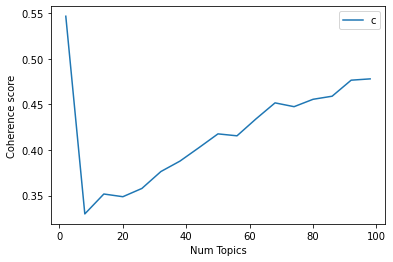

Wall time: 2min 21s


In [21]:
%%time
model_list, coherence_values = compute_coherence_values_lsi(dictionary=dictionary, corpus=corpus, texts=tokenized_texts_processed, start=2, limit=100, step=6)
# Show graph
import matplotlib.pyplot as plt
limit=100; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.figsize=(20,4)
plt.show()

In [22]:
model=LsiModel(corpus=corpus, id2word=dictionary, num_topics=10)
model.print_topics(num_topics=10, num_words=5)

[(0,
  '0.802*"россия" + 0.270*"сша" + 0.211*"украина" + 0.193*"заявить" + 0.169*"путин"'),
 (1,
  '0.582*"казахстан" + -0.411*"россия" + 0.398*"путин" + 0.311*"президент" + 0.243*"заявить"'),
 (2,
  '0.636*"казахстан" + -0.432*"путин" + -0.291*"сша" + -0.274*"украина" + 0.269*"россия"'),
 (3,
  '-0.598*"путин" + 0.470*"сша" + 0.289*"украина" + -0.211*"россия" + 0.203*"рф"'),
 (4,
  '-0.614*"заявить" + 0.424*"сша" + -0.309*"украина" + -0.243*"девятнадцать" + -0.237*"covid"'),
 (5,
  '-0.483*"девятнадцать" + -0.476*"covid" + 0.449*"украина" + -0.314*"сша" + 0.151*"газ"'),
 (6,
  '0.637*"заявить" + -0.448*"украина" + -0.273*"девятнадцать" + -0.269*"covid" + -0.240*"газ"'),
 (7,
  '-0.545*"газ" + -0.490*"европа" + 0.386*"украина" + -0.335*"цена" + 0.121*"президент"'),
 (8,
  '0.427*"нато" + 0.361*"рф" + 0.308*"безопасность" + -0.284*"санкция" + 0.282*"мид"'),
 (9,
  '-0.488*"президент" + 0.283*"рф" + 0.208*"северный" + 0.196*"поток" + -0.191*"сша"')]

#### LDA

In [23]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=2, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
lda_model.print_topics()

[(0,
  '0.027*"казахстан" + 0.008*"москва" + 0.007*"человек" + 0.006*"дело" + 0.006*"погибнуть" + 0.006*"код" + 0.006*"qr" + 0.006*"январь" + 0.005*"пять" + 0.005*"шесть"'),
 (1,
  '0.038*"россия" + 0.024*"сша" + 0.019*"заявить" + 0.012*"нато" + 0.011*"украина" + 0.011*"рф" + 0.010*"путин" + 0.010*"санкция" + 0.009*"против" + 0.009*"мид"')]

In [24]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

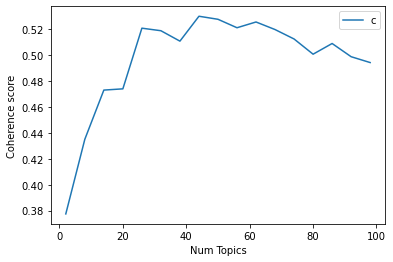

Wall time: 3min 18s


In [25]:
%%time
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=tokenized_texts_processed, start=2, limit=100, step=6)
# Show graph

limit=100; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [26]:
%%time

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=dictionary,
                                       num_topics=60)
lda_model.print_topics(num_topics=10, num_words=5)

Wall time: 7.92 s


[(5,
  '0.032*"россия" + 0.016*"путин" + 0.014*"назвать" + 0.009*"украина" + 0.009*"президент"'),
 (50,
  '0.020*"украина" + 0.020*"россия" + 0.019*"сша" + 0.015*"девятнадцать" + 0.015*"covid"'),
 (43,
  '0.017*"путин" + 0.016*"россия" + 0.010*"российский" + 0.009*"газ" + 0.008*"европа"'),
 (57,
  '0.033*"россия" + 0.016*"казахстан" + 0.015*"сша" + 0.011*"девятнадцать" + 0.010*"covid"'),
 (29,
  '0.017*"россия" + 0.013*"путин" + 0.010*"москва" + 0.010*"президент" + 0.010*"сша"'),
 (1,
  '0.019*"путин" + 0.016*"президент" + 0.010*"москва" + 0.010*"сша" + 0.009*"газ"'),
 (35,
  '0.018*"россия" + 0.008*"путин" + 0.008*"украина" + 0.008*"против" + 0.008*"президент"'),
 (58,
  '0.024*"россия" + 0.017*"путин" + 0.012*"казахстан" + 0.010*"сообщить" + 0.009*"президент"'),
 (46,
  '0.022*"россия" + 0.012*"казахстан" + 0.012*"сша" + 0.009*"заявить" + 0.008*"путин"'),
 (40,
  '0.021*"россия" + 0.011*"девятнадцать" + 0.010*"январь" + 0.009*"covid" + 0.008*"получить"')]

In [28]:
lda_model.print_topics(num_topics=10, num_words=5)

[(48,
  '0.020*"россия" + 0.011*"сша" + 0.010*"назвать" + 0.008*"военный" + 0.008*"казахстан"'),
 (49,
  '0.021*"казахстан" + 0.016*"украина" + 0.015*"россия" + 0.012*"сша" + 0.011*"путин"'),
 (56,
  '0.013*"россия" + 0.010*"заявить" + 0.009*"коронавирус" + 0.009*"президент" + 0.009*"этап"'),
 (24,
  '0.028*"россия" + 0.021*"путин" + 0.008*"заявить" + 0.007*"назвать" + 0.007*"сша"'),
 (40,
  '0.021*"россия" + 0.011*"девятнадцать" + 0.010*"январь" + 0.009*"covid" + 0.008*"получить"'),
 (35,
  '0.018*"россия" + 0.008*"путин" + 0.008*"украина" + 0.008*"против" + 0.008*"президент"'),
 (31,
  '0.018*"россия" + 0.011*"суд" + 0.011*"путин" + 0.010*"сша" + 0.007*"сообщить"'),
 (29,
  '0.017*"россия" + 0.013*"путин" + 0.010*"москва" + 0.010*"президент" + 0.010*"сша"'),
 (59,
  '0.041*"россия" + 0.012*"заявить" + 0.009*"казахстан" + 0.009*"сша" + 0.008*"украина"'),
 (42,
  '0.019*"россия" + 0.011*"коронавирус" + 0.009*"назвать" + 0.008*"путин" + 0.008*"европа"')]

#### Визуализация

In [31]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary, mds="mmds", R=30)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
50     0.114494 -0.031862       1        1  2.442805
34    -0.019174 -0.189256       2        1  2.361923
2      0.200145  0.015298       3        1  2.128437
39     0.076424 -0.220572       4        1  2.009139
25    -0.221588  0.018663       5        1  1.999871
37    -0.037260  0.153934       6        1  1.968123
30     0.205274  0.175855       7        1  1.959282
7      0.194925 -0.070684       8        1  1.931530
57     0.023554  0.005932       9        1  1.881140
14     0.230846 -0.036690      10        1  1.880062
17    -0.137441 -0.173322      11        1  1.862997
21    -0.205371  0.144026      12        1  1.841036
54     0.058282  0.074259      13        1  1.799392
45    -0.147296  0.136166      14        1  1.773881
20    -0.111615  0.024140      15        1  1.754721
0      0.141768  0.180068      16        1  1.752367
48    -0.061105  0.273327      17        1  1.722722
27    -0.126274  0.198253      18        1  1.721297
26     0.245573  0.093797      19        1  1.707361
13    -0.003762  0.077623      20        1  1.701624
40    -0.109291  0.242414      21        1  1.701019
12     0.041213 -0.061698      22        1  1.696499
32    -0.092338 -0.225372      23        1  1.693454
9      0.277188 -0.000338      24        1  1.680725
29    -0.012155  0.232249      25        1  1.676154
5      0.012916 -0.134543      26        1  1.664797
59     0.103542  0.015346      27        1  1.642014
52     0.013455 -0.272325      28        1  1.638815
33    -0.191380  0.200530      29        1  1.636973
38     0.072552  0.182393      30        1  1.636112
1      0.196708  0.132879      31        1  1.631038
49    -0.061177 -0.122181      32        1  1.625035
58    -0.036661 -0.065605      33        1  1.622052
10    -0.222534 -0.121737      34        1  1.620070
31     0.139771 -0.214424      35        1  1.619950
47     0.104339 -0.153249      36        1  1.615588
3     -0.272536 -0.076170      37        1  1.597547
15     0.125686 -0.115978      38        1  1.593313
55    -0.090700  0.121251      39        1  1.592463
24     0.242186  0.053151      40        1  1.590557
22    -0.143124 -0.119816      41        1  1.583760
46    -0.217037 -0.030751      42        1  1.582943
51    -0.195587  0.069582      43        1  1.574442
18     0.147185  0.095626      44        1  1.547429
4     -0.107164 -0.042918      45        1  1.545187
16    -0.254174  0.100741      46        1  1.528900
6     -0.266818  0.032387      47        1  1.508821
8      0.062246  0.137260      48        1  1.490618
11    -0.198234 -0.078021      49        1  1.471161
19     0.247375 -0.174305      50        1  1.462351
35    -0.214346 -0.190040      51        1  1.457155
41    -0.042129 -0.278694      52        1  1.456565
36     0.169631 -0.175032      53        1  1.431321
56     0.254014 -0.119856      54        1  1.424958
23     0.134128  0.239656      55        1  1.414068
42     0.072837 -0.266199      56        1  1.411271
28    -0.055002  0.031730      57        1  1.394783
44     0.068789  0.256618      58        1  1.351954
43    -0.141506 -0.244714      59        1  1.275216
53     0.017731  0.291197      60        1  1.113214, topic_info=             Term         Freq        Total Category  logprob  loglift
18         россия  1538.000000  1538.000000  Default  30.0000  30.0000
423        европа   260.000000   260.000000  Default  29.0000  29.0000
211  девятнадцать   282.000000   282.000000  Default  28.0000  28.0000
97          путин   706.000000   706.000000  Default  27.0000  27.0000
133       заявить   655.000000   655.000000  Default  26.0000  26.0000
..            ...          ...          ...      ...      ...      ...
245     президент     3.210992   450.819274  Topic60  -5.5077  -0.4466
98        украина     3.210885   621.581738  Topic60  -5.5077  -0.7678
183     казахстан     3.211904  